Making separate models for different Task IDs, repeating them several times and taking the average AUC.<br>
This model does not take into account second try.

In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))
student_vectors2 = json.load(open(filepath2))

In [3]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


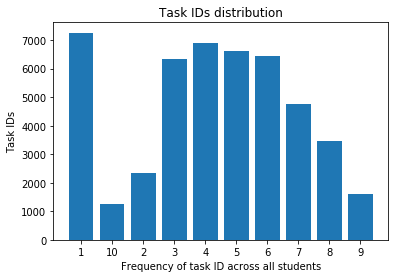

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7259 times. Max seq len: 46
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2325 times. Max seq len: 27
Task ID -> 1zsCldT4p8.set1(3) is attempted 6346 times. Max seq len: 39
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 6897 times. Max seq len: 40
Task ID -> 9wRCzK1G7F.partb(5) is attempted 6632 times. Max seq len: 43
Task ID -> 1zsCldT4p8.set2(6) is attempted 6443 times. Max seq len: 28
Task ID -> nl-M69Ez9k.parta(7) is attempted 4753 times. Max seq len: 56
Task ID -> kvig7fcCVc.partb(8) is attempted 3473 times. Max seq len: 32
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1589 times. Max seq len: 39
Task ID -> hyei4uD81i.parta(10) is attempted 1255 times. Max seq len: 40


In [18]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))

In [53]:
proportion_right = {}
proportion_wrong = {}
num_of_students = {}

for k in another_2:
    proportion_right[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    for i in student_vectors:
        question_number = 0
        right_wrong = []
        did_student_attempt = False
        for j in student_vectors[i]:
            if(j['second_try'] == False and j['task_id'] == k):
                question_number += 1
                did_student_attempt = True
                if(j['correct'] == True):
                    right_wrong.append('right')
                else:
                    right_wrong.append('wrong')
        if(did_student_attempt):
            for l in range(question_number):
                num_of_students[k][l] += 1
                if(right_wrong[l] == 'right'):
                    proportion_right[k][l] += 1
    for g in range(max(seqlen_tasks[k])):
        proportion_right[k][g] = round((proportion_right[k][g]) / (num_of_students[k][g]),4)
        proportion_wrong[k][g] = round(1.0 - proportion_right[k][g],4)

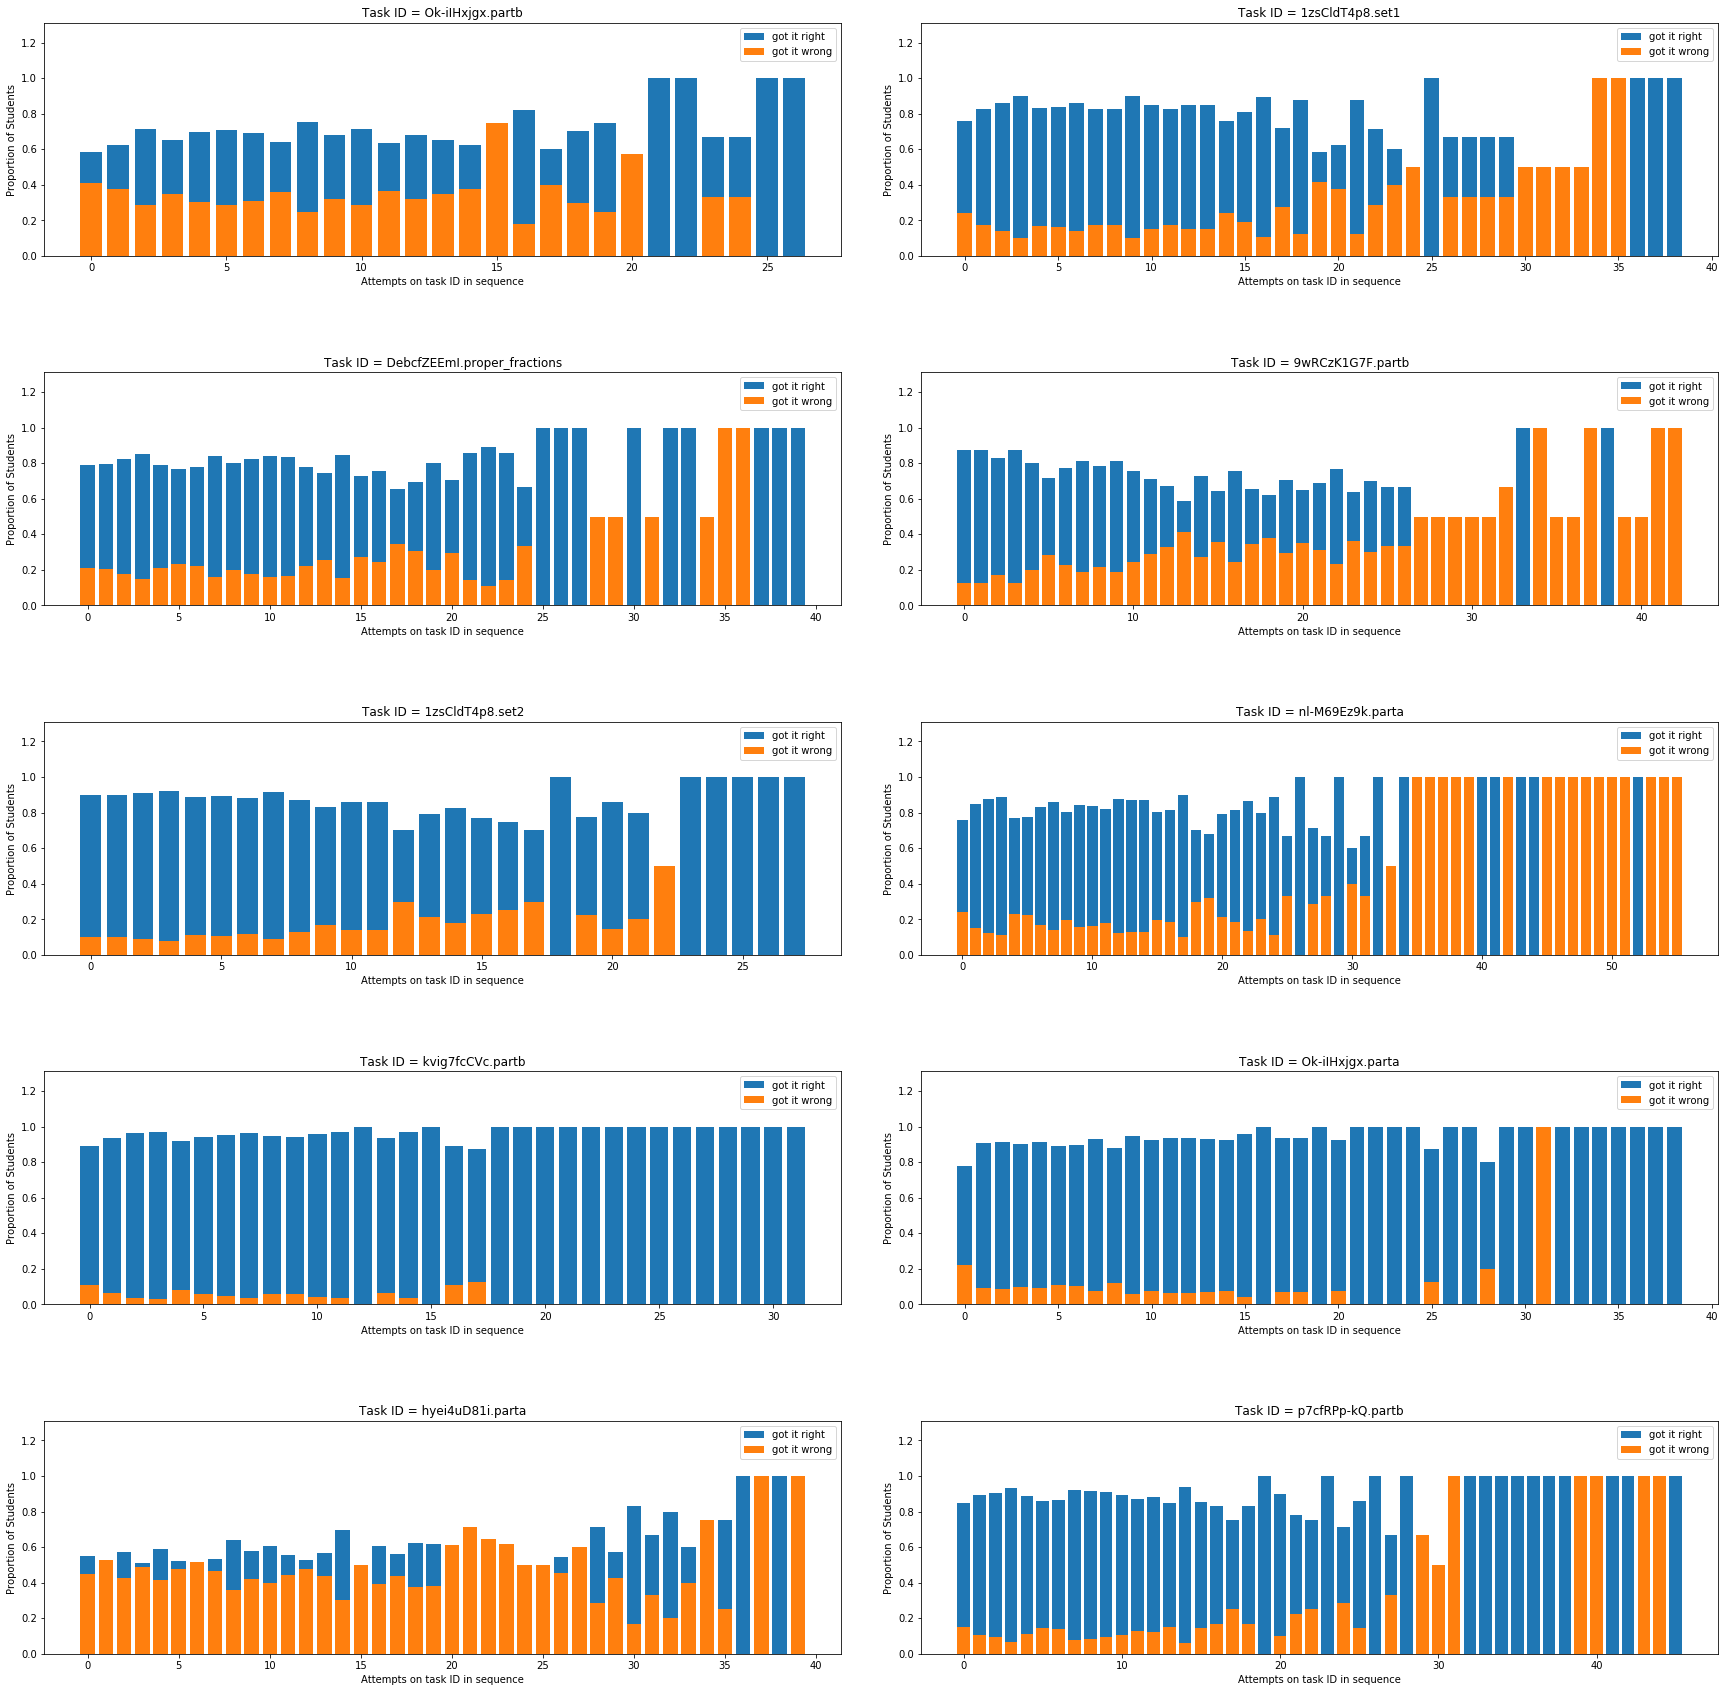

In [58]:
fig, axs = plt.subplots(5,2, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    axs[i-1].bar(ind,proportion_right[value],label="got it right")
    axs[i-1].bar(ind,proportion_wrong[value],label="got it wrong")
    axs[i-1].set_ylim(0,1.31)
    axs[i-1].legend(loc="best")
    axs[i-1].set_xlabel("Attempts on task ID in sequence")
    axs[i-1].set_ylabel("Proportion of Students")
    axs[i-1].set_title("Task ID = "+str(value))

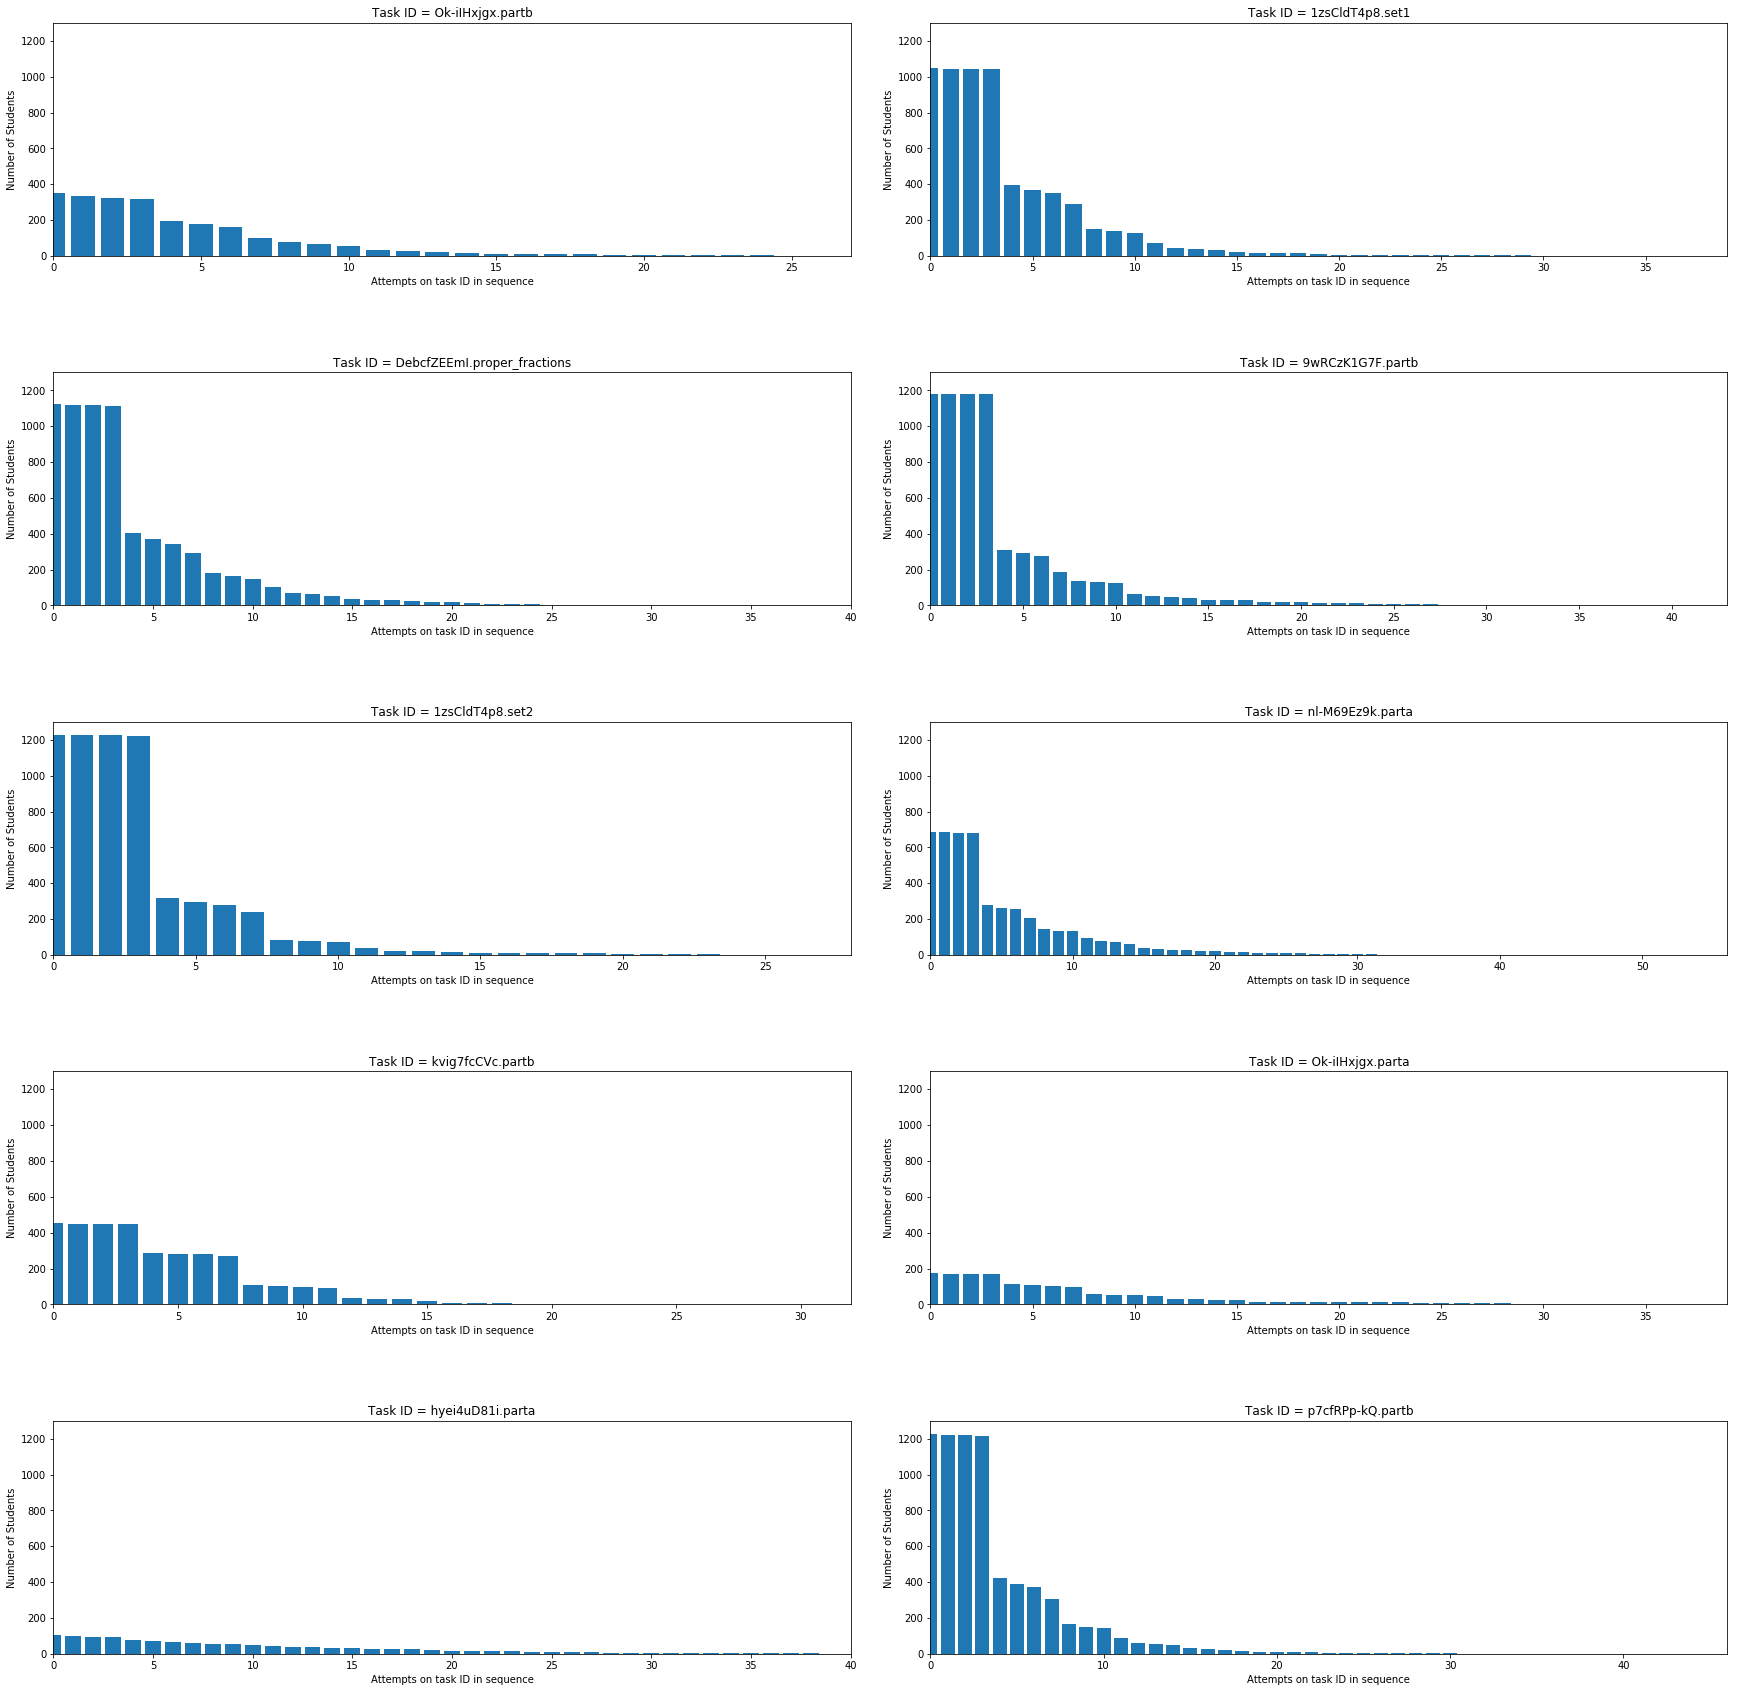

In [64]:
fig, axs = plt.subplots(5,2, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    axs[i-1].bar(ind,num_of_students[value])
    axs[i-1].set_ylim(0,1300)
    axs[i-1].set_xlim(0,max(seqlen_tasks[value]))
    axs[i-1].set_xlabel("Attempts on task ID in sequence")
    axs[i-1].set_ylabel("Number of Students")
    axs[i-1].set_title("Task ID = "+str(value))

In [13]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                else:
                    interactions.append([0.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)
            
    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),1])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 5
    len_vector = 1
    l_rate = 0.1
    epochs = 100
    display_ep = 20
    
    for r in range(10):
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid )
            #outputs = tf.nn.sigmoid(outputs)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        #optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) +":"+str(trainAUC) + ", test set AUC: "+ str(testOPTS)+":"+str(testAUC) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            #view_point = len(test_x) - 1 
            view_point = np.argsort(test_seqlen)[-2]
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = [np.mean(test_AUC_taski),np.std(test_AUC_taski)]
    train_AUC_all_tasks[i] = [np.mean(train_AUC_taski),np.std(train_AUC_taski)]




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7776



1 Time Run.
Step: 1, cost: 0.9096498, train set AUC: 0.9765727:0.0, test set AUC: 0.9766979:0.9765727;
Step: 20, cost: 0.7299834, train set AUC: 0.9059554:0.9766979, test set AUC: 0.9067423:0.9059554;
Step: 40, cost: 0.6857044, train set AUC: 0.92037994:0.9067423, test set AUC: 0.9225564:0.92037994;
Step: 60, cost: 0.676781, train set AUC: 0.92481714:0.9225564, test set AUC: 0.925297:0.92481714;
Step: 80, cost: 0.67383486, train set AUC: 0.92383736:0.925297, test set AUC: 0.92390996:0.92383736;
Step: 100, cost: 0.671867, train set AUC: 0.9230084:0.92390996, test set AUC: 0.9228821:0.9230084;


true:

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[9.5174497e-01]
 [9.9970502e-01]
 [9.9983847e-01]
 [7.3868926e-03]
 [9.8677641e-01]
 [9.9994934e-01]
 [9.9955565e-01]
 [5.8520242e-04]
 [9.9460524e-01]
 [9.9994266e-01]
 [9.9961662e-01]
 [5.868478

Step: 80, cost: 0.6746074, train set AUC: 0.9641662:0.9621577, test set AUC: 0.9648868:0.9641662;
Step: 100, cost: 0.6718915, train set AUC: 0.9645714:0.9648868, test set AUC: 0.9649033:0.9645714;


true:

[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.642574  ]
 [0.999483  ]
 [0.99981064]
 [0.9780086 ]
 [0.03750655]
 [0.99940526]
 [0.99991417]
 [0.97578377]
 [0.0254292 ]
 [0.99924743]
 [0.99991465]
 [0.9763787 ]
 [0.02477792]
 [0.9992192 ]
 [0.99991524]
 [0.9766251 ]
 [0.02465153]]


10 Time Run.
Step: 1, cost: 0.91049725, train set AUC: 0.9771905:0.0, test set AUC: 0.97732043:0.9771905;
Step: 20, cost: 0.7335743, train set AUC: 0.98152715:0.97732043, test set AUC: 0.9820514:0.98152715;
Step: 40, cost: 0.69073284, train set AUC: 0.9735759:0.9820514, test set AUC: 0.97328734:0.9735759;
Step: 60, cost: 0.6792721, train set AUC: 0.97484803:0.97328734, test set AUC: 0.97538763:0.97484803;
Step: 80, cost: 0.67525524,

Step: 80, cost: 0.6782828, train set AUC: 0.7632596:0.74738544, test set AUC: 0.76345444:0.7632596;
Step: 100, cost: 0.6761558, train set AUC: 0.7731959:0.76345444, test set AUC: 0.7720382:0.7731959;


true:

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


prediction

[[2.1572558e-03]
 [2.1067328e-07]
 [4.3961172e-09]
 [1.4727312e-09]
 [1.1574735e-09]
 [1.1015256e-09]
 [1.0898746e-09]
 [1.0871155e-09]
 [1.0863237e-09]
 [1.0860336e-09]
 [1.0859010e-09]
 [1.0858265e-09]
 [1.0857809e-09]
 [1.0857560e-09]
 [1.0857354e-09]
 [1.0857230e-09]
 [2.2856369e-08]]


8 Time Run.
Step: 1, cost: 0.88485163, train set AUC: 0.066086754:0.0, test set AUC: 0.06517467:0.066086754;
Step: 20, cost: 0.73373467, train set AUC: 0.5805439:0.06517467, test set AUC: 0.6284714:0.5805439;
Step: 40, cost: 0.69653594, train set AUC: 0.73640513:0.6284714, test set AUC: 0.7536597:0.73640513;
Step: 60, cost: 0.6848046, train set AUC: 0.78331745:0.7536597, test set

Step: 1, cost: 0.9043789, train set AUC: 0.96746874:0.0, test set AUC: 0.9661791:0.96746874;
Step: 20, cost: 0.7269763, train set AUC: 0.93908143:0.9661791, test set AUC: 0.93714404:0.93908143;
Step: 40, cost: 0.6855197, train set AUC: 0.9294196:0.93714404, test set AUC: 0.92741:0.9294196;
Step: 60, cost: 0.67819464, train set AUC: 0.92232335:0.92741, test set AUC: 0.9211914:0.92232335;
Step: 80, cost: 0.6749165, train set AUC: 0.9202123:0.9211914, test set AUC: 0.9196991:0.9202123;
Step: 100, cost: 0.67241603, train set AUC: 0.92028105:0.9196991, test set AUC: 0.9202108:0.92028105;


true:

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.9764697 ]
 [0.9999496 ]
 [0.99894375]
 [0.0108118 ]
 [0.9981547 ]
 [0.99999285]
 [0.99818206]
 [0.00534827]
 [0.9613688 ]
 [0.9999881 ]
 [0.99912566]
 [0.02890327]
 [0.9810783 ]
 [0.99998415]
 [0.99794966]
 [0.00327605]
 [0.9975089 ]
 [0.

Step: 1, cost: 0.9061083, train set AUC: 0.96536356:0.0, test set AUC: 0.96533567:0.96536356;
Step: 20, cost: 0.72919565, train set AUC: 0.9185224:0.96533567, test set AUC: 0.9156791:0.9185224;
Step: 40, cost: 0.68757755, train set AUC: 0.9099955:0.9156791, test set AUC: 0.9096938:0.9099955;
Step: 60, cost: 0.679242, train set AUC: 0.9075785:0.9096938, test set AUC: 0.9078585:0.9075785;
Step: 80, cost: 0.6760512, train set AUC: 0.90453273:0.9078585, test set AUC: 0.904042:0.90453273;
Step: 100, cost: 0.6742421, train set AUC: 0.90025127:0.904042, test set AUC: 0.8998854:0.90025127;


true:

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[3.1260002e-01]
 [1.7999798e-03]
 [6.0259877e-04]
 [4.5842840e-03]
 [1.1664134e-03]
 [1.6053269e-03]
 [9.9252945e-01]
 [6.0856336e-01]
 [4.5741826e-01]
 [9.9937624e-01]
 [9.7026807e-01]
 [9.6785458e-05]
 [9.5818174e-01]
 [9.9995053e-01]
 [9.9011606

Step: 60, cost: 0.6791062, train set AUC: 0.90715635:0.904001, test set AUC: 0.90789:0.90715635;
Step: 80, cost: 0.6757778, train set AUC: 0.9090282:0.90789, test set AUC: 0.90941423:0.9090282;
Step: 100, cost: 0.67398226, train set AUC: 0.9086392:0.90941423, test set AUC: 0.90863544:0.9086392;


true:

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[4.4871181e-01]
 [1.4142497e-02]
 [9.3078113e-04]
 [2.1354824e-02]
 [2.4500999e-03]
 [3.1026558e-03]
 [9.9336421e-01]
 [9.9246866e-01]
 [6.8082136e-01]
 [3.5498267e-01]
 [9.9956518e-01]
 [9.9941552e-01]
 [1.7071156e-04]
 [9.5910704e-01]
 [9.9997330e-01]
 [9.9337935e-01]
 [4.5879569e-05]
 [9.6804202e-01]
 [9.9997938e-01]
 [9.9252629e-01]
 [4.8466121e-05]
 [9.6899915e-01]
 [9.9997950e-01]]


10 Time Run.
Step: 1, cost: 0.9062128, train set AUC: 0.9651198:0.0, test set AUC: 0.96510667:0.9651198;
Step: 20, cost: 0.7296809, train set AUC: 0

Step: 1, cost: 0.9139563, train set AUC: 0.96906894:0.0, test set AUC: 0.9694292:0.96906894;
Step: 20, cost: 0.7363403, train set AUC: 0.83033264:0.9694292, test set AUC: 0.8280411:0.83033264;
Step: 40, cost: 0.6938776, train set AUC: 0.8806439:0.8280411, test set AUC: 0.8884101:0.8806439;
Step: 60, cost: 0.68506837, train set AUC: 0.89553916:0.8884101, test set AUC: 0.8993235:0.89553916;
Step: 80, cost: 0.68181574, train set AUC: 0.91386455:0.8993235, test set AUC: 0.9167692:0.91386455;
Step: 100, cost: 0.6800902, train set AUC: 0.92487216:0.9167692, test set AUC: 0.9267126:0.92487216;


true:

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.98006755]
 [0.99982953]
 [0.9995146 ]
 [0.1198722 ]
 [0.51703674]
 [0.5162758 ]
 [0.51627177]
 [0.5162652 ]
 [0.5162633 ]
 [0.51626277]
 [0.51626265]
 [0.51626265]
 [0.51626265]
 [0.51626265]
 [0.5109001 ]
 [0.5109967 ]
 [0.51099503]
 [0.51099503]]


8 Time Run.
Step: 1

Step: 1, cost: 0.88911617, train set AUC: 0.95745575:0.0, test set AUC: 0.9569843:0.95745575;
Step: 20, cost: 0.7080225, train set AUC: 0.94081926:0.9569843, test set AUC: 0.93677425:0.94081926;
Step: 40, cost: 0.6693031, train set AUC: 0.93500197:0.93677425, test set AUC: 0.9330772:0.93500197;
Step: 60, cost: 0.66110426, train set AUC: 0.93284273:0.9330772, test set AUC: 0.9319764:0.93284273;
Step: 80, cost: 0.6588041, train set AUC: 0.9324533:0.9319764, test set AUC: 0.93237233:0.9324533;
Step: 100, cost: 0.6577715, train set AUC: 0.9325169:0.93237233, test set AUC: 0.9319505:0.9325169;


true:

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[9.9928904e-01]
 [9.9997091e-01]
 [9.9884087e-01]
 [1.6789991e-04]
 [9.3384570e-01]
 [9.9994564e-01]
 [9.8868763e-01]
 [2.9468225e-04]
 [9.3455523e-01]
 [9.9998236e-01]
 [9.9862409e-01]
 [8.8916706e-05]
 [9.3311918e-01]
 [9.9998248e-01]
 [9.9921000e-01]
 [2.4

Step: 100, cost: 0.6798323, train set AUC: 0.90472126:0.9128146, test set AUC: 0.9040377:0.90472126;


true:

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[2.8092730e-01]
 [6.0169022e-03]
 [1.8448207e-03]
 [2.2185856e-02]
 [1.7211173e-03]
 [9.7547740e-01]
 [9.9797291e-01]
 [7.3253131e-04]
 [7.2296068e-02]
 [4.5279607e-01]
 [6.3082098e-04]
 [2.8492615e-02]
 [9.9944347e-01]
 [9.9650902e-01]
 [2.1090072e-03]
 [3.7230335e-02]
 [1.8298724e-01]
 [5.6936765e-01]
 [8.3033651e-01]
 [4.9256347e-04]
 [9.9213457e-01]
 [9.9999189e-01]
 [4.3976832e-02]
 [2.8960845e-01]]


3 Time Run.
Step: 1, cost: 0.91383594, train set AUC: 0.9771305:0.0, test set AUC: 0.97736704:0.9771305;
Step: 20, cost: 0.73446864, train set AUC: 0.9319353:0.97736704, test set AUC: 0.9308427:0.9319353;
Step: 40, cost: 0.6916947, train set AUC: 0.9218698:0.9308427, test set AUC: 0.92064905:0.9218698;
Step: 60, cost: 

Step: 1, cost: 0.9141622, train set AUC: 0.9770296:0.0, test set AUC: 0.97730535:0.9770296;
Step: 20, cost: 0.7344526, train set AUC: 0.9357322:0.97730535, test set AUC: 0.93311554:0.9357322;
Step: 40, cost: 0.69169027, train set AUC: 0.93279564:0.93311554, test set AUC: 0.93265563:0.93279564;
Step: 60, cost: 0.68254375, train set AUC: 0.9300376:0.93265563, test set AUC: 0.9297884:0.9300376;
Step: 80, cost: 0.6793088, train set AUC: 0.92517346:0.9297884, test set AUC: 0.9247083:0.92517346;
Step: 100, cost: 0.67732954, train set AUC: 0.92480206:0.9247083, test set AUC: 0.9248258:0.92480206;


true:

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[5.5895895e-01]
 [4.7965054e-03]
 [9.6054224e-05]
 [1.2341162e-02]
 [5.7852608e-03]
 [9.5844042e-01]
 [1.5195778e-01]
 [3.7029375e-05]
 [1.7637126e-02]
 [2.8384915e-01]
 [1.0470520e-04]
 [9.0725621e-04]
 [9.9612063e-01]
 [8.8059354e-0

Step: 20, cost: 0.6887088, train set AUC: 0.96981657:0.9639317, test set AUC: 0.9702144:0.96981657;
Step: 40, cost: 0.6544117, train set AUC: 0.9708815:0.9702144, test set AUC: 0.9709961:0.9708815;
Step: 60, cost: 0.6473016, train set AUC: 0.9710812:0.9709961, test set AUC: 0.97114086:0.9710812;
Step: 80, cost: 0.6447057, train set AUC: 0.9714741:0.97114086, test set AUC: 0.9715852:0.9714741;
Step: 100, cost: 0.6433107, train set AUC: 0.9717932:0.9715852, test set AUC: 0.971879:0.9717932;


true:

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.9962255 ]
 [0.99988985]
 [0.99993443]
 [0.99993896]
 [0.99993956]
 [0.9999397 ]
 [0.9999397 ]
 [0.99993956]
 [0.99993956]
 [0.9999397 ]
 [0.99993956]
 [0.9999397 ]
 [0.9999397 ]
 [0.9999397 ]
 [0.9999397 ]
 [0.9999397 ]
 [0.9999397 ]
 [0.9999397 ]]


9 Time Run.
Step: 1, cost: 0.8526312, train set AUC: 0.9631847:0.0, test set AUC: 0.9640067:0.9631847;
Step: 20, cost: 

Step: 1, cost: 0.85680246, train set AUC: 0.9727359:0.0, test set AUC: 0.9728569:0.9727359;
Step: 20, cost: 0.6972671, train set AUC: 0.97198015:0.9728569, test set AUC: 0.9721887:0.97198015;
Step: 40, cost: 0.66208214, train set AUC: 0.9725118:0.9721887, test set AUC: 0.97276396:0.9725118;
Step: 60, cost: 0.6513721, train set AUC: 0.97129375:0.97276396, test set AUC: 0.97104686:0.97129375;
Step: 80, cost: 0.64828026, train set AUC: 0.9711769:0.97104686, test set AUC: 0.9711798:0.9711769;
Step: 100, cost: 0.6467564, train set AUC: 0.97119856:0.9711798, test set AUC: 0.97116554:0.97119856;


true:

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


prediction

[[0.9934122 ]
 [0.99962306]
 [0.99977165]
 [0.99978834]
 [0.9997911 ]
 [0.99979156]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]
 [0.9997917 ]]


8 Time Run.
Step: 1, cost: 0.85813123, train set AUC: 0.9

Step: 1, cost: 0.8802005, train set AUC: 0.08149886:0.0, test set AUC: 0.07730179:0.08149886;
Step: 20, cost: 0.7397328, train set AUC: 0.2903715:0.07730179, test set AUC: 0.29282957:0.2903715;
Step: 40, cost: 0.70817417, train set AUC: 0.27908725:0.29282957, test set AUC: 0.27282265:0.27908725;
Step: 60, cost: 0.7012837, train set AUC: 0.25177604:0.27282265, test set AUC: 0.2463626:0.25177604;
Step: 80, cost: 0.6987219, train set AUC: 0.22940522:0.2463626, test set AUC: 0.22522044:0.22940522;
Step: 100, cost: 0.6973514, train set AUC: 0.21231456:0.22522044, test set AUC: 0.20909294:0.21231456;


true:

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


prediction

[[1.0241024e-03]
 [6.8709844e-05]
 [3.1285996e-05]
 [2.7129287e-05]
 [2.6722199e-05]
 [2.6668864e-05]
 [2.6661311e-05]
 [2.6660193e-05]
 [2.6660040e-05]
 [2.6660040e-05]
 [2.6660040e-05]
 [2.6660040e-05]
 [2.6660040e-05]
 [2.66600

In [10]:
pp.pprint(test_AUC_all_tasks)

{'1zsCldT4p8.set1': [0.9370896, 0.009525231],
 '1zsCldT4p8.set2': [0.9318983, 0.006146944],
 '9wRCzK1G7F.partb': [0.8926536, 0.014402596],
 'DebcfZEEmI.proper_fractions': [0.9071903, 0.008098661],
 'Ok-iIHxjgx.parta': [0.97164506, 0.00057482236],
 'Ok-iIHxjgx.partb': [0.7619863, 0.031558778],
 'hyei4uD81i.parta': [0.22808023, 0.019499244],
 'kvig7fcCVc.partb': [0.97120094, 0.0002357154],
 'nl-M69Ez9k.parta': [0.9366909, 0.018267903],
 'p7cfRPp-kQ.partb': [0.95865107, 0.018516647]}


In [11]:
pp.pprint(train_AUC_all_tasks)

{'1zsCldT4p8.set1': [0.9377906, 0.009313794],
 '1zsCldT4p8.set2': [0.9324771, 0.006548274],
 '9wRCzK1G7F.partb': [0.88958406, 0.015848795],
 'DebcfZEEmI.proper_fractions': [0.90730715, 0.007877714],
 'Ok-iIHxjgx.parta': [0.9715644, 0.0005406415],
 'Ok-iIHxjgx.partb': [0.7574048, 0.034095082],
 'hyei4uD81i.parta': [0.23194487, 0.020123305],
 'kvig7fcCVc.partb': [0.97116387, 0.00023536182],
 'nl-M69Ez9k.parta': [0.9374019, 0.018205116],
 'p7cfRPp-kQ.partb': [0.9585074, 0.01859145]}
